In [1]:
import logging
import os

import PIL.Image as Image

import ignite
import ignite.distributed as idist
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from WGANx64 import Generator, Critic
from utils import get_noise, get_gradient, gradient_penalty, get_gen_loss, get_crit_loss
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore, RunningAverage, SSIM

from torchsummary import summary
from torchvision.datasets import ImageFolder

# -------------------- Initialization --------------------

In [2]:
torch.manual_seed(999)
ignite.utils.manual_seed(999)

ignite.utils.setup_logger(
    name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING
)
ignite.utils.setup_logger(
    name="ignite.distributed.launcher.Parallel", level=logging.WARNING
)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

# -------------------- Configuration --------------------

In [3]:
image_size = 64
batch_size = 128
latent_dim = 100
n_channels = 3
n_epoch = 30
experiment_num = 6
save_threshold = 10
feature_dim = 128

c_lambda = 10
crit_repeats = 5

lr = 0.0001
beta_1 = 0
beta_2 = 0.9

fundus_type = "N"
model_name = f"WGANx64_{fundus_type}"

input_data_path = f"./processed/{fundus_type}"

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())

In [4]:
experiment_num = input("experiment number: ")

experiment number: 6


In [5]:
total_imgs = len(os.listdir(f"{input_data_path}/left/")) + len(os.listdir(f"{input_data_path}/right/"))

for i in range(1, 15):
    if (2 ** i) <= total_imgs:
        test_batch = 2 ** i
    
test_batch

2048

In [6]:
analysis_path = f"./analysis/{model_name}/{experiment_num}"

if not os.path.exists(analysis_path):
    os.makedirs(analysis_path)

# -------------------- Load Dataset --------------------

In [7]:
train_dataset = ImageFolder(root=input_data_path, transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(test_batch))

train_dataloader = idist.auto_dataloader(
    train_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False,
)

# -------------------- Plot Data --------------------

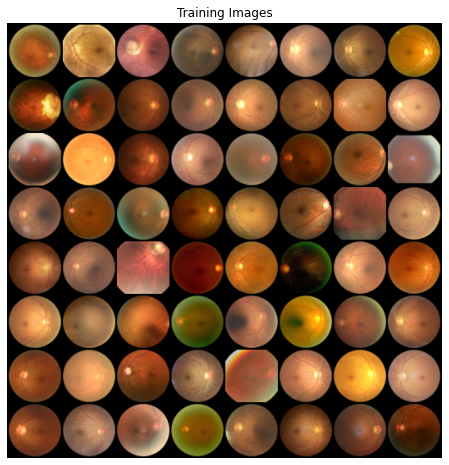

In [8]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),
        (1, 2, 0),
    )
)
plt.show()

# -------------------- Load Models --------------------

In [9]:
netG = idist.auto_model(Generator(latent_dim, feature_dim))
summary(netG, (latent_dim, 1, 1))

netD = idist.auto_model(Critic())
summary(netD, (n_channels, image_size, image_size))

# criterion = nn.BCELoss()

optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=lr, betas=(beta_1, beta_2))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=lr, betas=(beta_1, beta_2))
)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 64, 64]           --
|    └─ConvTranspose2d: 2-1              [-1, 2048, 4, 4]          3,278,848
|    └─BatchNorm2d: 2-2                  [-1, 2048, 4, 4]          4,096
|    └─ReLU: 2-3                         [-1, 2048, 4, 4]          --
|    └─ConvTranspose2d: 2-4              [-1, 1024, 8, 8]          33,555,456
|    └─BatchNorm2d: 2-5                  [-1, 1024, 8, 8]          2,048
|    └─ReLU: 2-6                         [-1, 1024, 8, 8]          --
|    └─ConvTranspose2d: 2-7              [-1, 512, 16, 16]         8,389,120
|    └─BatchNorm2d: 2-8                  [-1, 512, 16, 16]         1,024
|    └─ReLU: 2-9                         [-1, 512, 16, 16]         --
|    └─ConvTranspose2d: 2-10             [-1, 256, 32, 32]         2,097,408
|    └─BatchNorm2d: 2-11                 [-1, 256, 32, 32]         512
|    └─ReLU: 2-12                        [-1, 

# -------------------- Training Setup --------------------

In [10]:
torch.autograd.set_detect_anomaly(True)

In [11]:
def training_step(engine, batch):
    # Set the models for training
    netG.train()
    netD.train()

    real, _ = batch
    batch_size = len(real)
    real = real.to(idist.device())

    ############################
    # (1) Update C network
    ###########################
    
    mean_iteration_critic_loss = 0
    
    for _ in range(crit_repeats):
        optimizerD.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        fake = netG(noise)
        crit_fake_pred = netD(fake.detach()).reshape(-1)
        crit_real_pred = netD(real).reshape(-1)

        epsilon = torch.rand(len(real), 1, 1, 1, device=idist.device(), requires_grad=True)
        gradient = get_gradient(netD, real, fake.detach(), epsilon)
        gp = gradient_penalty(gradient)
        crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

        # Keep track of the average critic loss in this batch
        mean_iteration_critic_loss += crit_loss.item() / crit_repeats
        # Update gradients
        crit_loss.backward(retain_graph=True)
        # Update optimizer
        optimizerD.step()
        
    D_losses.append(mean_iteration_critic_loss)
    
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    optimizerG.zero_grad()
    noise_2 = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
    fake_2 = netG(noise_2)
    crit_fake_pred_2 = netD(fake_2).reshape(-1)

    gen_loss = get_gen_loss(crit_fake_pred_2)
    gen_loss.backward()

    # Update the weights
    optimizerG.step()

    # Keep track of the average generator loss
    G_losses.append(gen_loss.item())

    return {
        "Loss_G": gen_loss.item(),
        "Loss_D": crit_loss.item(),
        "D_x": crit_real_pred.mean().item(),
        "D_G_z1": crit_fake_pred.mean().item(),
        "D_G_z2": crit_fake_pred_2.mean().item(),
    }


trainer = Engine(training_step)


def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])


img_list = []


@trainer.on(Events.EPOCH_COMPLETED)
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

    plt.title("Fake Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),
            (1, 2, 0),
        )
    )
    plt.show()

# -------------------- Evaluation Setup --------------------

In [12]:
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(
    device=idist.device(), output_transform=lambda x: x[0]
)
ssim_metric = SSIM(data_range=1.0, device=idist.device())


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    global gReal, gFake
    gReal, _ = batch
    gReal = gReal.to(idist.device())
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        gFake = netG(noise)
        fake = interpolate(gFake)
        real = interpolate(gReal)
        return fake, real


evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")
# ssim_metric.attach(evaluator, "ssim")

previous_model = None

fid_values = []
is_values = []
ssim_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def save_model(engine):
    global previous_model, MODEL_PATH
    if engine.state.epoch < save_threshold:
        return
    if fid_values and (fid_values[-1] == min(fid_values)):
        print("Saving new model")
        MODEL_PATH = f"./models/{model_name}_n_epoch_{engine.state.epoch}_G_losses_{G_losses[-1]:4f}_D_losses_{D_losses[-1]:4f}_fid_{fid_values[-1]:4f}_is_{is_values[-1]:4f}_ssim_{ssim_values[-1]:4f}.pth"
        torch.save(netG, MODEL_PATH)
        if previous_model:
            print("Removing previous model")
            os.remove(previous_model)
        previous_model = MODEL_PATH


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    global gReal, gFake
    evaluator.run(test_dataloader, max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics["fid"]
    is_score = metrics["is"]
    fid_values.append(fid_score)
    is_values.append(is_score)
    
    ssim_metric = SSIM(data_range=1.0, device=idist.device())
    ssim_metric.update((gFake, gReal))
    ssim_score = float(ssim_metric.compute())
    ssim_values.append(ssim_score)
    
    print(f"Epoch [{engine.state.epoch}/{n_epoch}] Metric Scores")
    print(f"*       FID : {fid_score:4f}")
    print(f"*        IS : {is_score:4f}")
    print(f"*      SSIM : {ssim_score:4f}")
    print(f"*  G_losses : {G_losses[-1]:4f}")
    print(f"*  D_losses : {D_losses[-1]:4f}")
    

# -------------------- Training Visual Setup --------------------

In [13]:
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, "Loss_G")
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, "Loss_D")

ProgressBar().attach(trainer, metric_names=["Loss_G", "Loss_D"])
ProgressBar().attach(evaluator)

# -------------------- Begin Training --------------------

[1/23]   4%|4          [00:00<?]

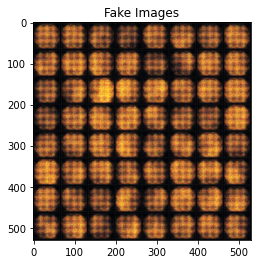

[1/16]   6%|6          [00:00<?]

Epoch [1/30] Metric Scores
*       FID : 0.211973
*        IS : 1.216084
*      SSIM : 0.089409
*  G_losses : 12.605662
*  D_losses : -21.077660


[1/23]   4%|4          [00:00<?]

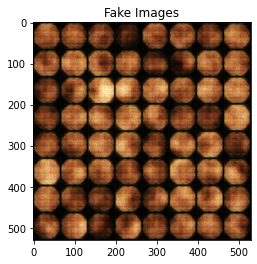

[1/16]   6%|6          [00:00<?]

Epoch [2/30] Metric Scores
*       FID : 0.061365
*        IS : 1.452344
*      SSIM : 0.154392
*  G_losses : 21.332781
*  D_losses : -18.738525


[1/23]   4%|4          [00:00<?]

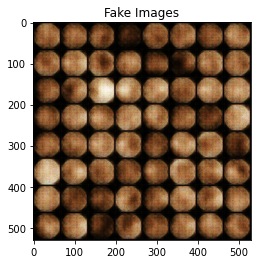

[1/16]   6%|6          [00:00<?]

Epoch [3/30] Metric Scores
*       FID : 0.051997
*        IS : 1.519771
*      SSIM : 0.173290
*  G_losses : 24.167532
*  D_losses : -19.312330


[1/23]   4%|4          [00:00<?]

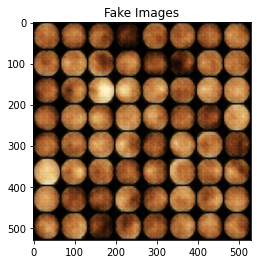

[1/16]   6%|6          [00:00<?]

Epoch [4/30] Metric Scores
*       FID : 0.071503
*        IS : 1.619162
*      SSIM : 0.199052
*  G_losses : 29.720373
*  D_losses : -22.413975


[1/23]   4%|4          [00:00<?]

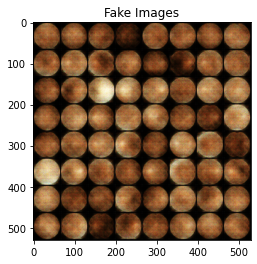

[1/16]   6%|6          [00:00<?]

Epoch [5/30] Metric Scores
*       FID : 0.043947
*        IS : 1.639416
*      SSIM : 0.211171
*  G_losses : 36.098999
*  D_losses : -15.595784


[1/23]   4%|4          [00:00<?]

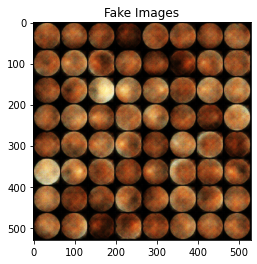

[1/16]   6%|6          [00:00<?]

Epoch [6/30] Metric Scores
*       FID : 0.049757
*        IS : 1.619009
*      SSIM : 0.230094
*  G_losses : 34.561699
*  D_losses : -16.221760


[1/23]   4%|4          [00:00<?]

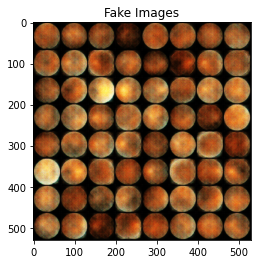

[1/16]   6%|6          [00:00<?]

Epoch [7/30] Metric Scores
*       FID : 0.080829
*        IS : 1.632531
*      SSIM : 0.214267
*  G_losses : 37.157429
*  D_losses : -17.314468


[1/23]   4%|4          [00:00<?]

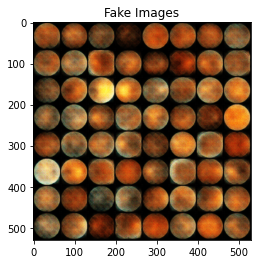

[1/16]   6%|6          [00:00<?]

Epoch [8/30] Metric Scores
*       FID : 0.090360
*        IS : 1.698231
*      SSIM : 0.230228
*  G_losses : 31.255548
*  D_losses : -14.746189


[1/23]   4%|4          [00:00<?]

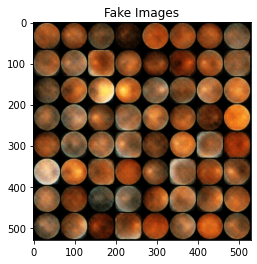

[1/16]   6%|6          [00:00<?]

Epoch [9/30] Metric Scores
*       FID : 0.055445
*        IS : 1.697151
*      SSIM : 0.228728
*  G_losses : 40.159859
*  D_losses : -12.080883


[1/23]   4%|4          [00:00<?]

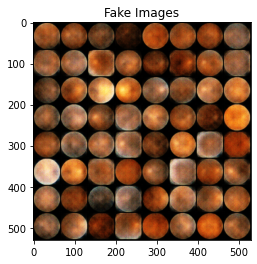

[1/16]   6%|6          [00:00<?]

Epoch [10/30] Metric Scores
*       FID : 0.070672
*        IS : 1.755321
*      SSIM : 0.235075
*  G_losses : 41.065048
*  D_losses : -14.651538


[1/23]   4%|4          [00:00<?]

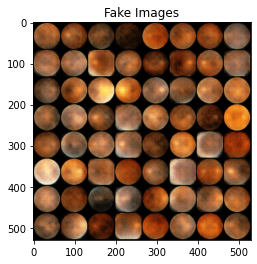

[1/16]   6%|6          [00:00<?]

Epoch [11/30] Metric Scores
*       FID : 0.049388
*        IS : 1.724160
*      SSIM : 0.238891
*  G_losses : 39.604084
*  D_losses : -14.044888


[1/23]   4%|4          [00:00<?]

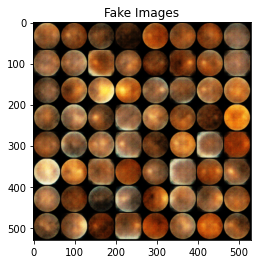

[1/16]   6%|6          [00:00<?]

Epoch [12/30] Metric Scores
*       FID : 0.075456
*        IS : 1.758610
*      SSIM : 0.232940
*  G_losses : 38.054379
*  D_losses : -10.834103


[1/23]   4%|4          [00:00<?]

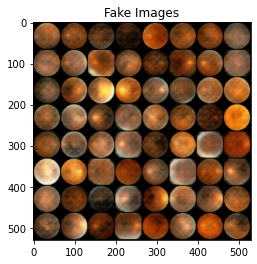

[1/16]   6%|6          [00:00<?]

Epoch [13/30] Metric Scores
*       FID : 0.100146
*        IS : 1.730683
*      SSIM : 0.252910
*  G_losses : 39.748188
*  D_losses : -9.474820


[1/23]   4%|4          [00:00<?]

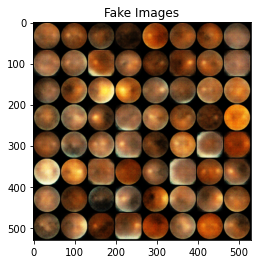

[1/16]   6%|6          [00:00<?]

Epoch [14/30] Metric Scores
*       FID : 0.066715
*        IS : 1.759842
*      SSIM : 0.243606
*  G_losses : 38.626492
*  D_losses : -8.490389


[1/23]   4%|4          [00:00<?]

In [ ]:
def training(*args):
    trainer.run(trai_dataloader, max_epochs=n_epoch)


with idist.Parallel(backend="nccl") as parallel:
    parallel.run(training)

# -------------------- Model Inference --------------------

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.savefig(f"{analysis_path}/loss.png")

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.title("SSIM Evaluation")
plt.plot(ssim_values)
plt.xlabel("iterations")
plt.ylabel("SSIM Value")
plt.legend()

plt.savefig(f"{analysis_path}/ssid.png")

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = "tab:red"
ax1.set_xlabel("epochs")
ax1.set_ylabel("IS", color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = "tab:blue"
ax2.set_ylabel("FID", color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()
plt.savefig(f"{analysis_path}/inception.png")

In [ ]:
try:
    model = torch.load(MODEL_PATH)
except:
    print("model path not defined")
    model = netG

with torch.no_grad():
    fake = model(fixed_noise).cpu()  

In [ ]:
MODEL_PATH

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(fake, padding=2, normalize=True).cpu(),
        (1, 2, 0),
    )
)

plt.savefig(f"{analysis_path}/fake_n_real.png")

In [ ]:
# %matplotlib inline

# # Grab a batch of real images from the dataloader
# real_batch = next(iter(train_dataloader))

# # Plot the real images
# plt.figure(figsize=(15, 15))
# plt.subplot(1, 2, 1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(
#     np.transpose(
#         vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),
#         (1, 2, 0),
#     )
# )

# # Plot the fake images from the last epoch
# plt.subplot(1, 2, 2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(
#     np.transpose(
#         vutils.make_grid(img_list[26], padding=2, normalize=True).cpu(),
#         (1, 2, 0),
#     )
# )

# plt.savefig(f"{analysis_path}/fake_n_real.png")

In [ ]:
# MODEL_PATH = f"./models/{model_name}_n_epoch_35_G_losses_{G_losses[-1]:4f}_D_losses_{D_losses[-1]:4f}_fid_{fid_values[-1]:4f}_is_{is_values[-1]:4f}_ssim_{ssim_values[-1]:4f}.pth"
# torch.save(netG, MODEL_PATH)